In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 10000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    # cluster jets from the particles in one observation
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)): # for each jet get (px, py, pz, e)
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [7]:
loaded_data = data
# data = loaded_data

In [8]:
data = np.array(data)
data.shape

(1477373, 4)

In [9]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [10]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [ 4.42306312e-01,  9.70780337e-02,  2.58945478e+01,
         2.58985070e+01],
       [-2.68772115e-01, -3.44070287e-01, -3.01572220e+01,
         3.01603823e+01],
       [-2.82745626e-01, -7.48815701e-02, -9.38791569e+00,
         9.39247109e+00]])

In [11]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [12]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [13]:
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.03073949 0.0307984  0.38423165 1.        ]


# VAE Model

In [14]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [15]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [17]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [18]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [19]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [20]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [21]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
batch_size = 1000
epochs = 200

In [24]:
x_train.shape

(1181898, 4)

In [25]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [26]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/200
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.0392 - val_loss: 0.0158
Epoch 2/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0157 - val_loss: 0.0156
Epoch 3/200
1181898/1181898 [==============================] - 6s 5us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 4/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 6/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 7/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 8/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 9/200
1181898/1181898 [==============================] - 7s 6us/step 

# Visualization

In [27]:
import matplotlib.pyplot as plt

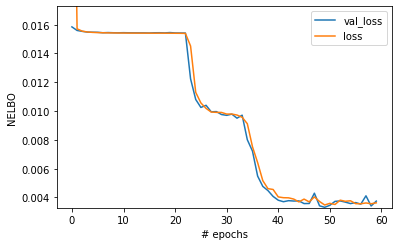

In [28]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [29]:
predictions = vae.predict(x_test)

In [30]:
predictions

array([[ 0.00105369, -0.00898808, -0.00980585, -0.48981845],
       [ 0.00122571,  0.01611   , -0.17192908, -0.3706953 ],
       [-0.01470208, -0.0127846 ,  0.01493505, -0.4891429 ],
       ...,
       [-0.01884434, -0.00841296,  0.05769125, -0.46195227],
       [ 0.00264382, -0.00192928, -0.0441277 , -0.4650994 ],
       [-0.00199312, -0.0064764 , -0.00273394, -0.49347913]],
      dtype=float32)

In [31]:
distr = (x_test - predictions) / x_test

In [32]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [33]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [34]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([   435.,    390.,    424.,    432.,    422.,    495.,    511.,
           562.,    589.,    617.,    603.,    630.,  73189.,  19658.,
          9145.,   5889.,   4338.,   3729.,   3455.,   3631.,   5730.,
          5520.,   8578.,  24003., 284871.,  21569.,   7965.,   5471.,
          3627.,   2654.,   2186.,   1738.,   1527.,   1460.,   1267.,
          1170.,   1078.,    972.,    987.,    903.,    855.,    798.,
           803.,    838.,    806.,    737.,    699.,    699.,    749.]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
         0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.

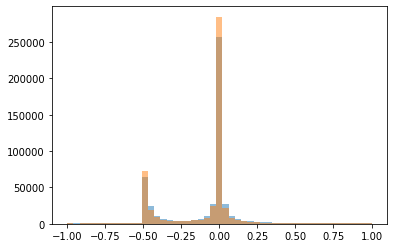

In [35]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([  1657.,   1682.,   1817.,   1987.,   2219.,   2374.,   2499.,
          2795.,   3356.,   4117.,   5262.,   7292.,  13771.,  39217.,
        182484.,  27699.,  14072.,  10216.,   8833.,   9696.,  14826.,
         18904.,  15224.,   8993.,   5791.,   4678.,   3870.,   3455.,
          3177.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

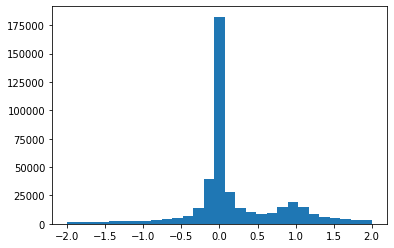

In [36]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for px, py, pz, E

(array([5.8000e+01, 1.7500e+02, 7.0000e+02, 6.6700e+02, 3.0300e+02,
        2.4300e+02, 2.6400e+02, 2.8300e+02, 2.7500e+02, 3.0500e+02,
        3.0400e+02, 3.3600e+02, 4.7500e+02, 1.5540e+03, 1.7900e+03,
        1.5240e+03, 1.6240e+03, 1.9412e+04, 5.9709e+04, 3.4834e+04,
        2.5680e+03, 3.1000e+01, 2.8000e+01, 3.1000e+01, 3.4000e+01,
        3.1000e+01, 3.5000e+01, 2.2000e+01, 2.4000e+01, 3.1000e+01,
        2.7000e+01, 1.9000e+01, 2.9000e+01, 1.8000e+01, 3.6000e+01,
        3.3000e+01, 3.9000e+01, 3.1000e+01, 2.3000e+01]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.1179

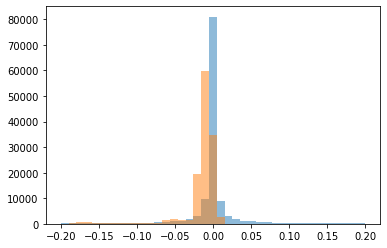

In [37]:
# px
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [38]:
print(mse(px,px_pred))

tf.Tensor(0.10560149, shape=(), dtype=float32)


(array([5.7000e+01, 6.5000e+01, 6.7000e+01, 6.7000e+01, 1.0500e+02,
        1.2600e+02, 1.9200e+02, 2.2600e+02, 1.5900e+02, 1.2200e+02,
        1.2000e+02, 1.3900e+02, 3.2400e+02, 8.4800e+02, 1.0610e+03,
        1.5590e+03, 2.2270e+03, 2.3790e+03, 8.2314e+04, 1.5295e+04,
        6.4270e+03, 8.9270e+03, 9.4300e+02, 6.2400e+02, 4.5100e+02,
        4.1800e+02, 3.2500e+02, 2.4000e+02, 2.0000e+02, 1.5200e+02,
        1.6200e+02, 1.7600e+02, 1.5100e+02, 1.2500e+02, 1.0400e+02,
        9.4000e+01, 6.0000e+01, 5.1000e+01, 5.8000e+01]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.1179

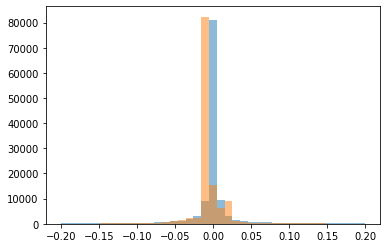

In [39]:
# py
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [40]:
print(mse(py,py_pred))

tf.Tensor(0.15681137, shape=(), dtype=float32)


(array([  333.,   350.,   402.,   435.,   457.,   519.,   532.,   597.,
          663.,   766.,   873.,   942.,  1211.,  1476.,  1503.,  2192.,
         3107.,  4531.,  7589., 48073., 15936.,  7902.,  3549.,  3341.,
         2431.,  1821.,  1463.,  1129.,  1013.,   815.,   704.,   644.,
          582.,   565.,   502.,   410.,   435.,   364.,   347.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

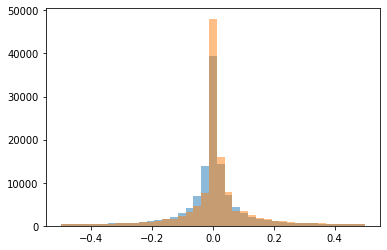

In [41]:
# pz
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [42]:
print(mse(pz,pz_pred))

tf.Tensor(0.0043610297, shape=(), dtype=float32)


(array([    0.,     0.,     0.,     0., 56200., 21858., 10124.,  6595.,
         4221.,  3187.,  2470.,  2008.,  1529.,  1393.,  1120.,  1055.,
         1005.,   794.,   752.,   660.,   623.,   572.,   502.,   409.,
          501.,   438.,   401.,   381.,   339.,   451.,   414.,   366.,
          288.,   236.,   273.,   239.,   249.,   233.,   185.]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.11538462,  0.13846154,  0.16153846,  0.18461538,
         0.20769231,  0.23076923,  0.25384615,  0.27692308,  0.3       ]),
 <a list of 39 Patch objects>)

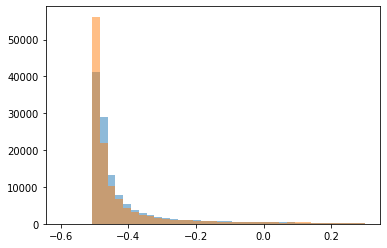

In [43]:
# E
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [44]:
print(mse(e,e_pred))

tf.Tensor(0.0050632986, shape=(), dtype=float32)


In [45]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [46]:
bins = np.linspace(-2, 2, 30)

(array([ 633.,  642.,  697.,  743.,  872.,  875.,  938.,  984., 1072.,
        1115., 1378., 1569., 2048., 3217., 4976., 5938., 3821., 2764.,
        2615., 2956., 4467., 8491., 6554., 3389., 2292., 1940., 1606.,
        1444., 1306.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

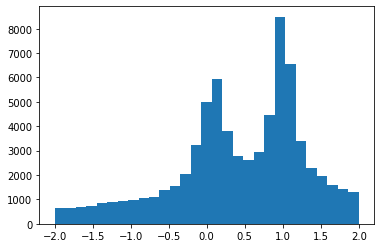

In [47]:
plt.hist(d_px, bins=bins)

(array([ 734.,  734.,  755.,  819.,  821.,  913.,  942.,  992., 1051.,
        1166., 1356., 1498., 2221., 3468., 5182., 4013., 3031., 2807.,
        2991., 3174., 4202., 5520., 4974., 3107., 2290., 1832., 1479.,
        1423., 1320.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

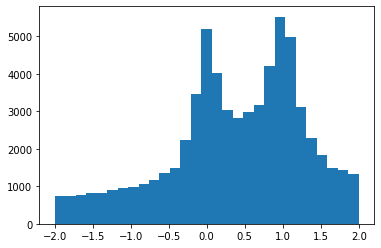

In [48]:
plt.hist(d_py, bins=bins)

(array([  288.,   299.,   360.,   415.,   514.,   574.,   602.,   796.,
         1192.,  1752.,  2384.,  3890.,  8520., 24872., 40579., 12465.,
         6362.,  4440.,  3182.,  3540.,  6138.,  4872.,  3683.,  2483.,
         1200.,   896.,   778.,   582.,   550.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

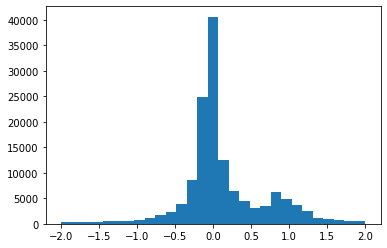

In [49]:
plt.hist(d_pz, bins=bins)

(array([2.00000e+00, 7.00000e+00, 5.00000e+00, 1.00000e+01, 1.20000e+01,
        1.20000e+01, 1.70000e+01, 2.30000e+01, 4.10000e+01, 8.40000e+01,
        1.44000e+02, 3.35000e+02, 9.82000e+02, 7.66000e+03, 1.31747e+05,
        5.28300e+03, 8.58000e+02, 2.05000e+02, 4.50000e+01, 2.60000e+01,
        1.90000e+01, 2.10000e+01, 1.30000e+01, 1.40000e+01, 9.00000e+00,
        1.00000e+01, 7.00000e+00, 6.00000e+00, 1.00000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

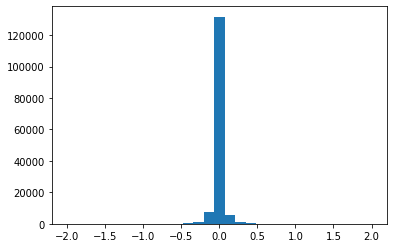

In [50]:
plt.hist(d_e, bins=bins)

# Anomaly Detection

In [59]:
from sklearn.metrics import mean_squared_error

In [51]:
test_pred = vae.predict(x_test)

In [56]:
def mse_list(x,y):
    return mean_squared_error(x_test, test_pred)

In [65]:
# get the mse of all predictions
errors = (np.square(x_test - test_pred)).mean(axis=1)

In [82]:
np.quantile(errors,0.9998)

7.325605888801482

In [88]:
np.unique((errors > np.quantile(errors,0.95)), return_counts = True)

(array([False,  True]), array([140351,   7387]))